This notebook trains the CWW+SB4 templates

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle, copy
from scipy.interpolate import interp1d

from modules import get_bandpass_dict, get_eff_wavelen, Sed, \
                    create_training_sets, train_templates

In [2]:
# plotting style
%config InlineBackend.figure_format = 'retina'
plt.style.use('paper.mplstyle')
twocol = 7.1014
onecol = 3.35

Load the filters

In [3]:
bandpass_dict = get_bandpass_dict()

Load the galaxy redshift catalog

In [4]:
with open('data/training_catalog.pkl', 'rb') as input:
    galaxies = pickle.load(input)

Load the CWW+SB4 templates

In [56]:
cwwsb4_templates = dict()
step = 100
lambda_min = 10
lambda_max = 15000

x, y = np.loadtxt('templates/El_B2004a.sed',unpack=True)
sed = Sed()
sed.wavelen = np.arange(lambda_min,lambda_max,step,dtype=float)
sed.flambda = np.interp(sed.wavelen,x,y)
cwwsb4_templates['El'] = sed

x, y = np.loadtxt('templates/Sbc_B2004a.sed',unpack=True)
sed = Sed()
sed.wavelen = np.arange(lambda_min,lambda_max,step,dtype=float)
sed.flambda = np.interp(sed.wavelen,x,y)
cwwsb4_templates['Sbc'] = sed

x, y = np.loadtxt('templates/Scd_B2004a.sed',unpack=True)
sed = Sed()
sed.wavelen = np.arange(lambda_min,lambda_max,step,dtype=float)
sed.flambda = np.interp(sed.wavelen,x,y)
cwwsb4_templates['Scd'] = sed

x, y = np.loadtxt('templates/Im_B2004a.sed',unpack=True)
sed = Sed()
sed.wavelen = np.arange(lambda_min,lambda_max,step,dtype=float)
sed.flambda = np.interp(sed.wavelen,x,y)
cwwsb4_templates['Im'] = sed

x, y = np.loadtxt('templates/SB3_B2004a.sed',unpack=True)
sed = Sed()
sed.wavelen = np.arange(lambda_min,lambda_max,step,dtype=float)
sed.flambda = np.interp(sed.wavelen,x,y)
cwwsb4_templates['SB3'] = sed

x, y = np.loadtxt('templates/SB2_B2004a.sed',unpack=True)
sed = Sed()
sed.wavelen = np.arange(lambda_min,lambda_max,step,dtype=float)
sed.flambda = np.interp(sed.wavelen,x,y)
cwwsb4_templates['SB2'] = sed

x, y = np.loadtxt('templates/ssp_25Myr_z008.sed',unpack=True)
sed = Sed()
sed.wavelen = np.arange(lambda_min,lambda_max,step,dtype=float)
sed.flambda = np.interp(sed.wavelen,x,y)
cwwsb4_templates['25Myr'] = sed

x, y = np.loadtxt('templates/ssp_5Myr_z008.sed',unpack=True)
sed = Sed()
sed.wavelen = np.arange(lambda_min,lambda_max,step,dtype=float)
sed.flambda = np.interp(sed.wavelen,x,y)
cwwsb4_templates['5Myr'] = sed

I will lower the spectral line in SB2 to avoid the huge dips the algorithm creates (note: each time you run the following cell, it will divide by 4. If you accidentally run it twice, re-run the cell above, then run the following cell only once)

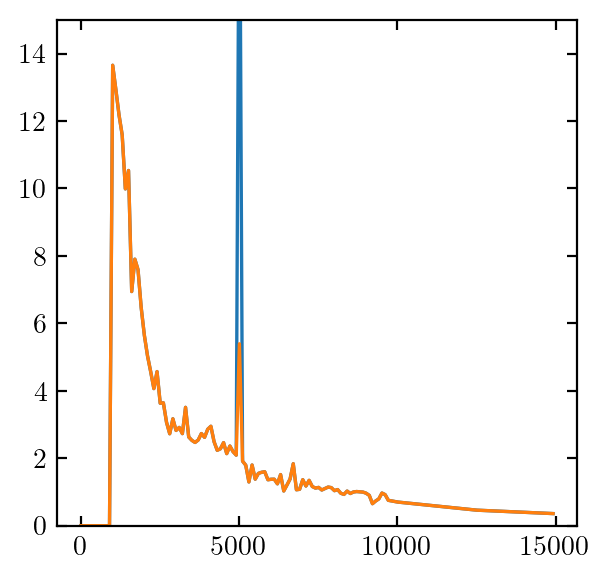

In [57]:
template = cwwsb4_templates['SB2']
plt.plot(template.wavelen,template.flambda)
idx = np.fabs(template.wavelen-5000).argmin()
template.flambda[idx] /= 4
plt.plot(template.wavelen,template.flambda)
plt.ylim(0,15)
plt.show()

Create training sets and plot them

In [37]:
%%time
training_sets = create_training_sets(cwwsb4_templates, galaxies, bandpass_dict)

CPU times: user 1min 48s, sys: 188 ms, total: 1min 48s
Wall time: 1min 48s


Number of fluxes in each training set:
[41547, 81260, 131483, 82777, 47122, 24749, 2610, 180]


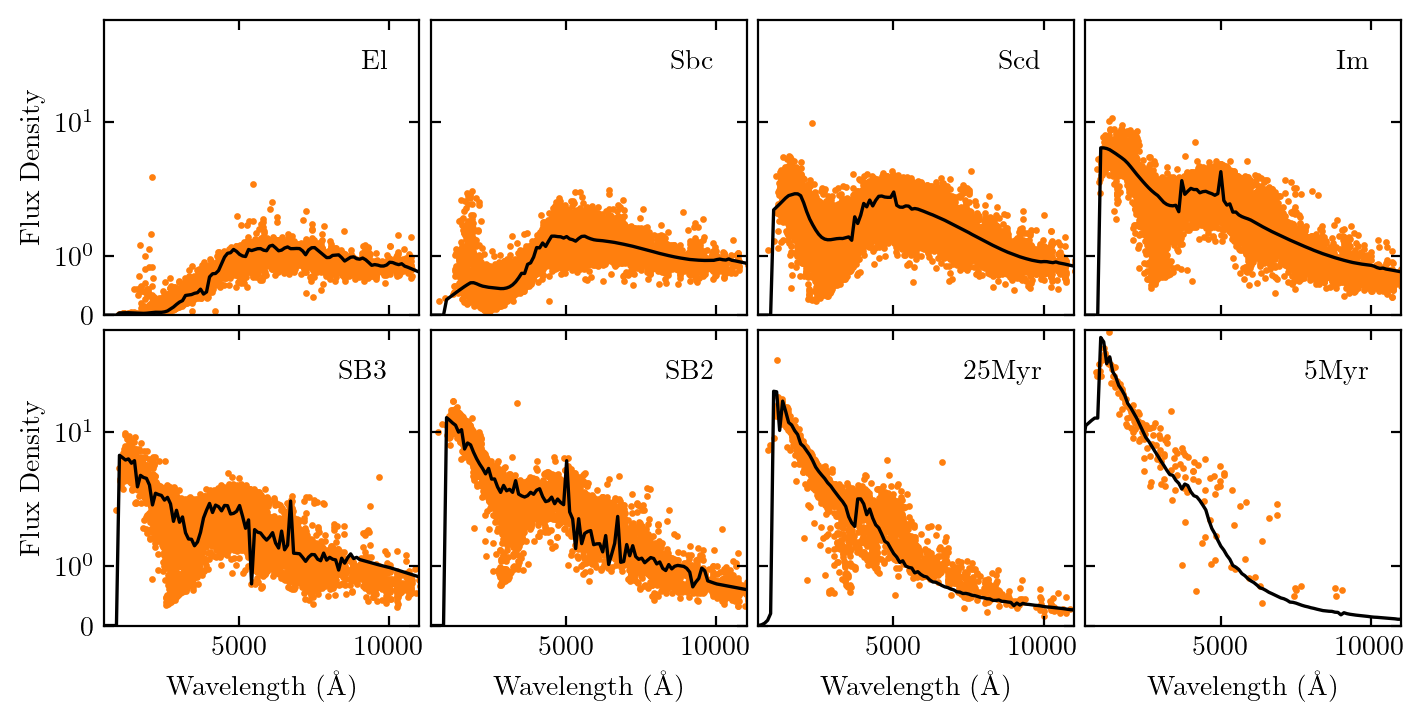

In [38]:
fig, axes = plt.subplots(2,4,sharex='all',sharey='all',figsize=(twocol,twocol*1/2))

print("Number of fluxes in each training set:")
print([len(i) for i in training_sets.values()])

for (ax,template) in zip(axes.flatten(),cwwsb4_templates):
    
    wavelen = [row[0] for row in training_sets[template]]
    fluxes = [row[1] for row in training_sets[template]]
    ax.scatter(wavelen, fluxes, s=2, c="C1")
    
    sed = cwwsb4_templates[template]
    ax.plot(sed.wavelen, sed.flambda, ls="-", c="k")
    
    ax.text(0.9,0.9,template,transform=ax.transAxes,ha="right",va="top")

plt.xlim(500,11000)
plt.ylim(0,90)
plt.yscale('symlog')

for ax in axes[-1,:]:
    ax.set_xlabel('Wavelength ($\mathrm{\AA}$)')
for ax in axes[:,0]:
    ax.set_ylabel('Flux Density')

fig.tight_layout(pad=0.5, h_pad=0, w_pad=0)
plt.show()

#fig.savefig('plots/cwwsb4_untrained.png')

Now train the templates

In [41]:
%%time
trained_templates, final_sets = train_templates(cwwsb4_templates, galaxies, bandpass_dict, N_iter=3, w=2, renorm=False)

Round 1/5
Round 2/5
Round 3/5
Round 4/5
Round 5/5
Generating final sets
Done!
CPU times: user 23min 29s, sys: 2.97 s, total: 23min 32s
Wall time: 22min 9s


Save the results!

In [44]:
"""for template in trained_templates:
    file = open('templates/'+template+'_trained.sed','w')
    x = copy.copy(trained_templates[template].wavelen)
    y = copy.copy(trained_templates[template].flambda)
    # upsample to every 10 angstroms
    xnew = np.arange(x[0],x[-1],10)
    ynew = np.interp(xnew,x,y)
    for i in range(len(xnew)):
        file.write("{0:<10.2f}{1:<10.4f}\n".format(xnew[i],ynew[i]))
    file.close()""";

Plot the results

In [6]:
""""# Load the trained templates from files if you didn't run the training algorithm
trained_templates = dict()
for template in cwwsb4_templates:
    x,y = np.loadtxt('templates/'+template+'_trained.sed',unpack=True)
    trained_templates[template] = Sed(x,y)
    
final_sets = create_training_sets(trained_templates, galaxies, bandpass_dict)"""";

Number of fluxes in each training set:
[48831, 60780, 88630, 75445, 84231, 39269, 5622, 8920]


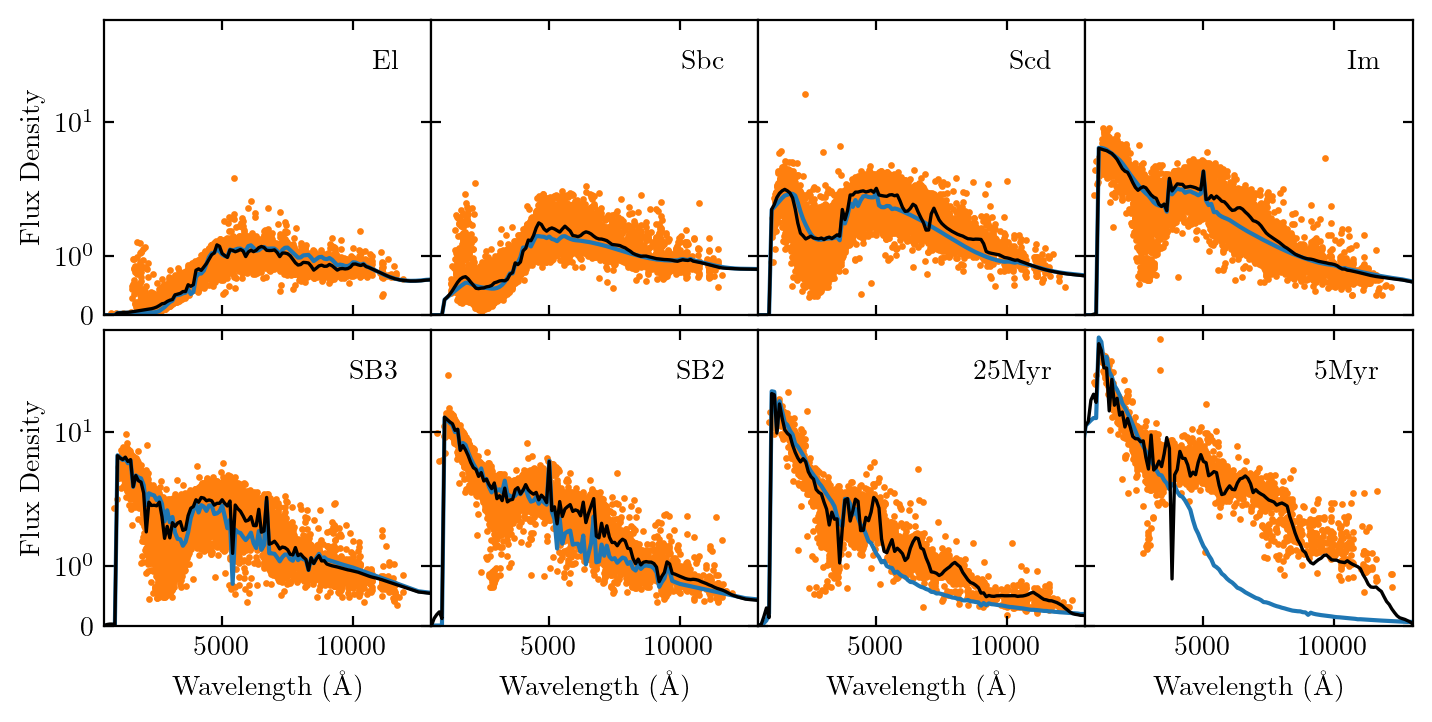

In [58]:
fig, axes = plt.subplots(2,4,sharex='all',sharey='all',figsize=(twocol,1/2*twocol))

print("Number of fluxes in each training set:")
print([len(i) for i in final_sets.values()])

for (ax,template) in zip(axes.flatten(),trained_templates):
    
    wavelen = [row[0] for row in final_sets[template]]
    fluxes = [row[1] for row in final_sets[template]]
    ax.scatter(wavelen, fluxes, s=2, c="C1")
    
    sed = cwwsb4_templates[template]
    ax.plot(sed.wavelen, sed.flambda, ls="-", c="C0", lw=1.5)
    
    sed = trained_templates[template]
    ax.plot(sed.wavelen, sed.flambda, ls="-", c="k")
    
    ax.text(0.9,0.9,template,transform=ax.transAxes,ha="right",va="top")

plt.xlim(500,13000)
plt.ylim(0,90)
plt.yscale('symlog')

for ax in axes[-1,:]:
    ax.set_xlabel('Wavelength ($\mathrm{\AA}$)')
for ax in axes[:,0]:
    ax.set_ylabel('Flux Density')
    
fig.tight_layout(pad=0.5, h_pad=0, w_pad=0)
plt.show()

#fig.savefig('plots/cwwsb4_trained.png')